# Zero-shot classification with Vision Language Models

> Jelen Jupyter notebook a Budapesti Műszaki és Gazdaságtudományi Egyetemen tartott "Deep Learning a gyakorlatban Python és LUA alapon" tantárgy segédanyagaként készült.
>
> A tantárgy honlapja: http://smartlab.tmit.bme.hu/oktatas-deep-learning
>
> Deep Learning kutatás: http://smartlab.tmit.bme.hu/deep-learning
>
> A notebook bármely részének újra felhasználása, publikálása csak a szerzők írásos beleegyezése esetén megegengedett.
>
> 2025 (c) Kalapos András (kalapos pont andras kukac tmit pont bme pont hu)*

Kód alapja: https://huggingface.co/timm/ViT-SO400M-16-SigLIP2-384

## Imports

In [ ]:
!pip install --quiet\
    open-clip-torch==2.32.0\
    timm==1.0.15

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 61.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.6 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn.functional as F
import requests
from urllib.request import urlopen
from PIL import Image
import matplotlib.pyplot as plt

## Load CLIP-like model
The selected model is a SigLIP2 pretrained Vision transformer downloaded from HuggingFace.

In [ ]:
from open_clip import create_model_from_pretrained, get_tokenizer # works on open-clip-torch >= 2.31.0, timm >= 1.0.15


model, preprocess = create_model_from_pretrained('hf-hub:timm/ViT-SO400M-16-SigLIP2-384')
tokenizer = get_tokenizer('hf-hub:timm/ViT-SO400M-16-SigLIP2-384')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_model.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

open_clip_config.json:   0%|          | 0.00/984 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/34.4M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

## Download test images

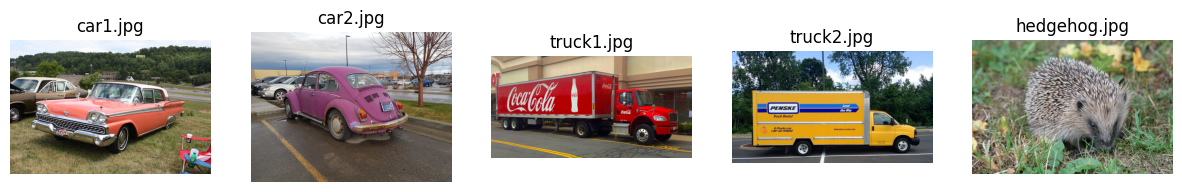

In [ ]:
samples = (
("https://live.staticflickr.com/3527/3764217982_72ba3b30a0_w_d.jpg", "car1.jpg"),
("https://live.staticflickr.com/65535/32774110507_d87ef144df_c_d.jpg", "car2.jpg"),
("https://live.staticflickr.com/1693/26112040703_33d4c48e81_c_d.jpg", "truck1.jpg"),
("https://live.staticflickr.com/3895/14511339682_db718c322a_c_d.jpg", "truck2.jpg"),
("https://live.staticflickr.com/3/2582/3811713563_75bd1b2a77_z.jpg", "hedgehog.jpg")
)

samples = [(Image.open(urlopen(url)), label) for url, label in samples]

fig, axs = plt.subplots(1, len(samples), figsize=(15, 15))
for i, (image,label) in enumerate(samples):
    axs[i].imshow(image)
    axs[i].set_title(label)
    axs[i].axis('off')
plt.show()

### Upload additional images (optional)

Saving green-wooden-old-door-background.jpeg to green-wooden-old-door-background (1).jpeg
User uploaded file "green-wooden-old-door-background (1).jpeg" with length 335076 bytes


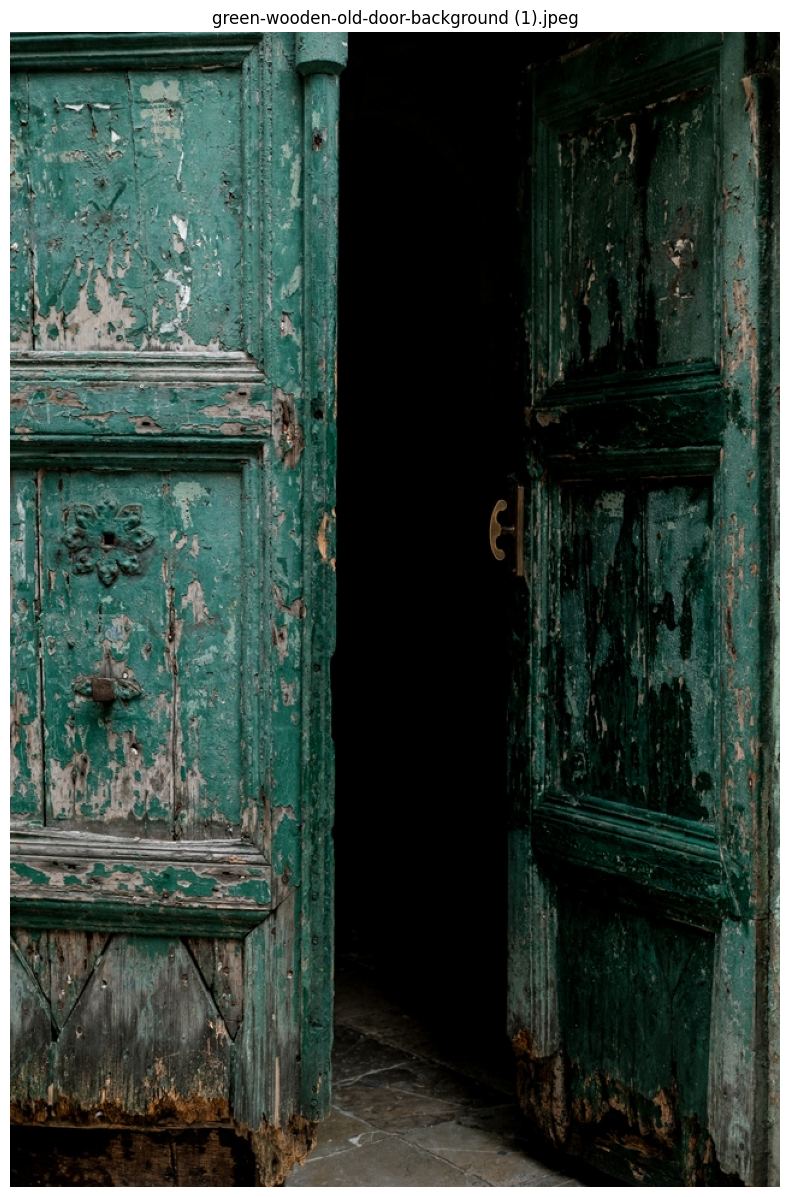

In [ ]:
from google.colab import files

uploaded = files.upload()
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  image = Image.open(fn)
  samples.append((image, fn))

fig, axs = plt.subplots(1, len(uploaded), figsize=(15, 15))
if len(uploaded) == 1:
    axs = [axs]
for i, (image,label) in enumerate(samples[-len(uploaded):]):
    axs[i].imshow(image)
    axs[i].set_title(label)
    axs[i].axis('off')
plt.show()

## Make prediction

In [ ]:
#1  Define possible labels
labels_list = ['a photo of a car', 'a photo of a truck']

#2 Tokenize & Encode possible labels
text = tokenizer(labels_list, context_length=model.context_length)
with torch.no_grad(), torch.amp.autocast('cuda'):
    text_features = model.encode_text(text, normalize=True)

#3 Run prediction
for image, label in samples:
    image = preprocess(image).unsqueeze(0)
    with torch.no_grad(), torch.amp.autocast('cuda'):
        #3a Get image embeddings
        image_features = model.encode_image(image, normalize=True)
        #3b Compute similarity between text and image embeddings
        text_probs = torch.sigmoid(image_features @ text_features.T * model.logit_scale.exp() + model.logit_bias)

    zipped_list = list(zip(labels_list, [100 * round(p.item(), 4) for p in text_probs[0]]))
    print(f"Label probabilities for {label}:", *[f"  \"{l}\": {score:0.3f}" for l, score in zipped_list], sep='\n')
    print("")


Label probabilities for car1.jpg:
  "a photo of a car": 0.230
  "a photo of a truck": 0.000

Label probabilities for car2.jpg:
  "a photo of a car": 0.650
  "a photo of a truck": 0.000

Label probabilities for truck1.jpg:
  "a photo of a car": 0.010
  "a photo of a truck": 3.100

Label probabilities for truck2.jpg:
  "a photo of a car": 0.020
  "a photo of a truck": 2.180

Label probabilities for hedgehog.jpg:
  "a photo of a car": 0.000
  "a photo of a truck": 0.000



In [ ]:
#1  Define possible labels
labels_list = ['a photo of a car', 'a photo of a truck', 'a photot of a hedgehog']

#2 Tokenize & Encode possible labels
text = tokenizer(labels_list, context_length=model.context_length)
with torch.no_grad(), torch.amp.autocast('cuda'):
    text_features = model.encode_text(text, normalize=True)

#3 Run prediction
image, label = samples[4]
image = preprocess(image).unsqueeze(0)
with torch.no_grad(), torch.amp.autocast('cuda'):
    #3a Get image embeddings
    image_features = model.encode_image(image, normalize=True)
    #3b Compute similarity between text and image embeddings
    text_probs = torch.sigmoid(image_features @ text_features.T * model.logit_scale.exp() + model.logit_bias)

zipped_list = list(zip(labels_list, [100 * round(p.item(), 3) for p in text_probs[0]]))
print(f"Label probabilities for {label}:", *[f"  \"{l}\": {score:0.3f}" for l, score in zipped_list], sep='\n')
print("")


Label probabilities for hedgehog.jpg:
  "a photo of a car": 0.000
  "a photo of a truck": 0.000
  "a photot of a hedgehog": 80.100



**Feladat**:
- írjátok a neptun kódotokat a notebook fájlnevébe VLM_megoldás_NEPTUN1_NEPTUN2.ipynb formában!
- Fokozatosan kísérletezzétek ki a bemutatott zero-shot osztályozás határait!
- Találjatok ki nehezebb, részletesebb osztályoka! Mi az amit még el lehet különíteni az itt bemutatott módon, mi az amit már nem?